# Project 3: Poisonous Mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [8]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from scipy.spatial.distance import cdist


In [3]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [4]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))

Loaded feature names:  126


In [5]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Part 1:

Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

When k = 1 fraction of the total variance explained:
16.4%
When k = 2 fraction of the total variance explained:
29.73%
When k = 3 fraction of the total variance explained:
39.9%
When k = 4 fraction of the total variance explained:
46.96%
When k = 5 fraction of the total variance explained:
50.83%
When k = 6 fraction of the total variance explained:
54.51%
When k = 7 fraction of the total variance explained:
57.64%
When k = 8 fraction of the total variance explained:
60.37%
When k = 9 fraction of the total variance explained:
62.99%
When k = 10 fraction of the total variance explained:
65.22%
When k = 11 fraction of the total variance explained:
67.27%
When k = 12 fraction of the total variance explained:
69.14%
When k = 13 fraction of the total variance explained:
70.87%
When k = 14 fraction of the total variance explained:
72.56%
When k = 15 fraction of the total variance explained:
74.08%
When k = 16 fraction of the total variance explained:
75.58%
When k = 17 fraction of the total v

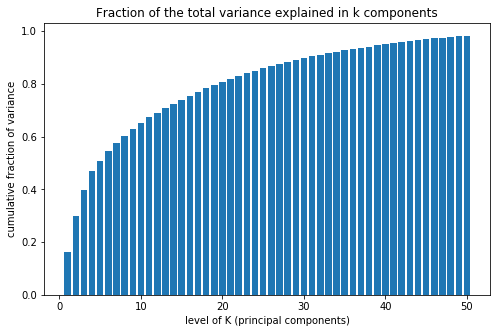

In [6]:
def P1():
### STUDENT START ###
    pca = PCA()
    pca.fit(train_data)
    
    k = 50 
    partial_variance = pca.explained_variance_ratio_[:k].cumsum()
    for i in range(k):
        print("When k = " + str(i+1) + " fraction of the total variance explained:")
        print(str(round(partial_variance[i]*100, 2)) + "%")
        
    plt.figure(figsize=(8,5))
    plt.title('Fraction of the total variance explained in k components')
    plt.xlabel('level of K (principal components)')
    plt.ylabel('cumulative fraction of variance')
    plt.bar(np.arange(1,51),partial_variance)
    plt.show()

### STUDENT END ###

P1()

### Part 2:

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

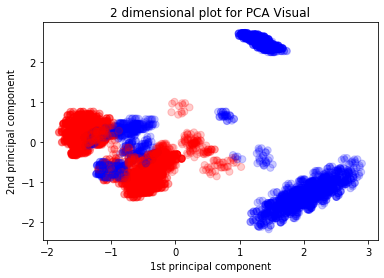

In [7]:
def P2():
### STUDENT START ###
    #2 principal components 2 dimentional
    pca1 = PCA(n_components = 2)
    train_pc = pca1.fit_transform(train_data)
    color = np.where(train_labels == 1, 'blue','red')
    
    #creating a graph
    plt.scatter(train_pc[:,0],train_pc[:,1],c=color, alpha =0.2, s = 50)
    plt.xlabel("1st principal component")
    plt.ylabel("2nd principal component")
    plt.title("2 dimensional plot for PCA Visual")

### STUDENT END ###

P2()

### Part 3:

Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

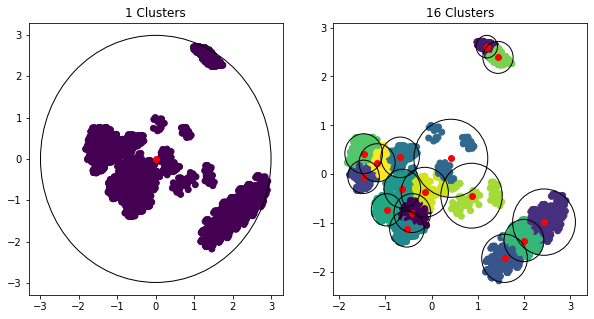

In [9]:
def P3():
    
    fig = plt.figure(figsize=(10, 5))
    count = 1

    # project data to two dimensions
    pca_mod = PCA(n_components = 2)
    pca_dat = pca_mod.fit_transform(train_data)
    
    # setup KMeans model and separate data
    for i in [1,16]:
        model = KMeans(n_clusters=i)
        model.fit(pca_dat)
        labels = model.labels_
        centers = model.cluster_centers_
        predicted_cluster = model.predict(pca_dat)
        distanceMax = np.zeros(len(centers))

        # calculate distance between points to decide furthest point
        for j in range(len(pca_dat)):
            clusters = centers[predicted_cluster[j]]
            distanceX = (pca_dat[j][0]-clusters[0])**2
            distanceY = (pca_dat[j][1]-clusters[1])**2
            total_distance = (distanceX + distanceY)**(.5)
            if total_distance > distanceMax[predicted_cluster[j]]:
                distanceMax[predicted_cluster[j]]=total_distance
        plots = fig.add_subplot(1,2,count)

        # plot data points
        plots.scatter(pca_dat[:,0], pca_dat[:,1], c = labels)

        # plot circles and center points
        for k in range(len(centers)):
            cir = plt.Circle(centers[k], radius = distanceMax[k], color = "black", fill = False)
            plots.add_patch(cir)
            plots.scatter(model.cluster_centers_[k][0], model.cluster_centers_[k][1], color = "red")
        plt.title(str(i) + " Clusters")
        count+=1
    plt.show()

P3()

### Part 4:

Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Log scale: values of z <= 0 have been masked
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Log scale: values of z <= 0 have been masked
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Log scale: values of z <= 0 have been masked
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Log scale: values of z <= 0 have been masked
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Log scale: values of z <= 0 have been masked
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Log scale: values of z <= 0 have been masked
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Log scale: values of z <= 0 have been masked
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Log scale: values of z <= 0 have been masked
//anacon

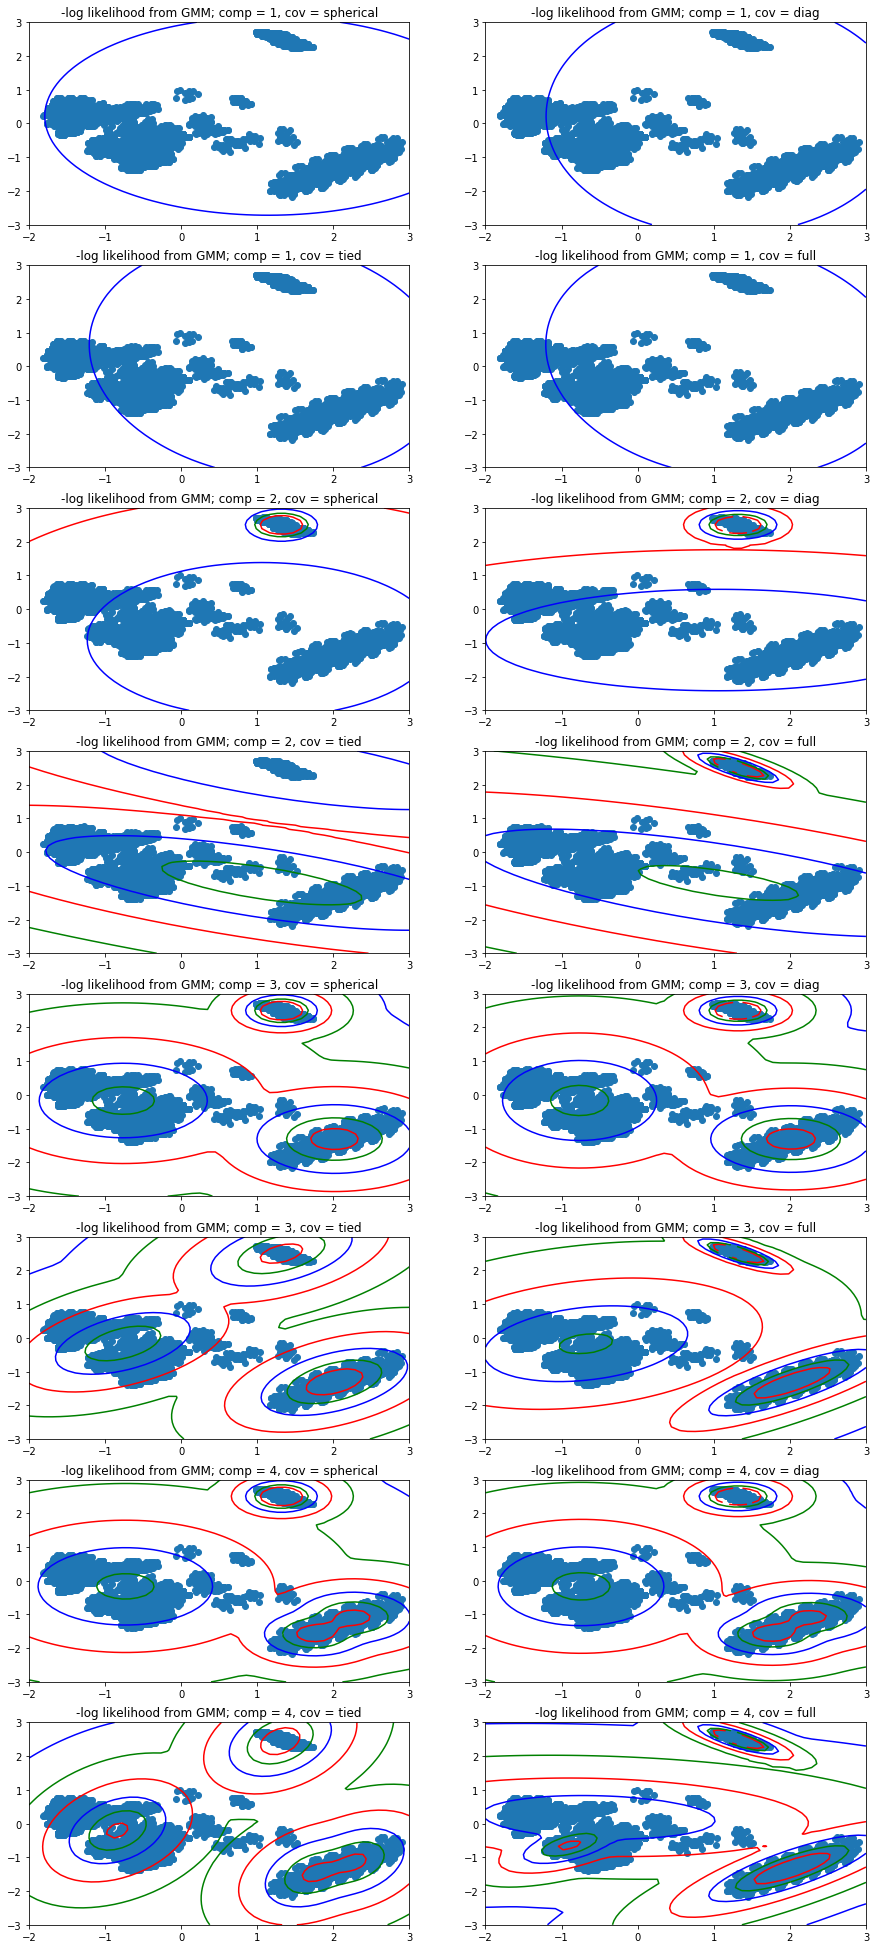

In [58]:
def P4():
    
    fig = plt.figure(figsize=(15, 35))
    count=1

    # get positive data
    pos_labels = np.where(train_labels == 1)
    n_comp = 2
    pca_mod = PCA(n_components = n_comp)
    pca_dat = pca_mod.fit_transform(train_data)
    pos_pca = pca_dat[pos_labels]

    for gmm_n_comp in range(4):
        for covar in ["spherical","diag","tied","full"]:

            
            model = GaussianMixture(n_components=gmm_n_comp+1, covariance_type=covar)
            model.fit(pos_pca)

            # display predicted scores by the model as a contour plot
            x = np.linspace(-2., 3.)
            y = np.linspace(-3., 3.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -model.score_samples(XX)
            Z = Z.reshape(X.shape)
           

            #plot contour map
            plots = fig.add_subplot(8,2,count)
            CS = plots.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), colors=('r', 'g', 'b'), levels=np.logspace(0, 3, 10))
            #CB = plt.colorbar(CS, shrink=0.8, extend='both')
            plots.scatter(pca_dat[:, 0], pca_dat[:, 1])
            plots.axis('tight')
            title = "-log likelihood from GMM; comp = " + str(gmm_n_comp+1) + ", cov = " + covar
            plt.title(title)
            count+=1
    plt.show()

P4()

### Part 5:

Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [6]:
def P5():
### STUDENT START ###

        # 2d projected data
    pca_mod = PCA(n_components=2)
    reduced_train_data = pca_mod.fit_transform(train_data)
    reduced_test_data = pca_mod.transform(test_data)
        # positive examples 
    pos_train = reduced_train_data[train_labels == 1]
        # negative examples
    neg_train = reduced_train_data[train_labels == 0]
    
        # fit 4-component full covariance GMM for positive examples
    gmm_p = GaussianMixture(n_components = 4, covariance_type = 'full')
    gmm_p.fit(pos_train)
    pos_probs = np.exp(gmm_p.score_samples(reduced_test_data))
    
        # fit 4-component full covariance GMM for negative examples
    gmm_n = GaussianMixture(n_components = 4, covariance_type = 'full')
    gmm_n.fit(neg_train)
    neg_probs = np.exp(gmm_n.score_samples(reduced_test_data))
    
        # predict the test examples by choosing the label for which the model gives a larger probability
    predictions = []
    
    for i in range(len(reduced_test_data)):
        if pos_probs[i] <= neg_probs[i]: 
            predictions.append(0)
        else: predictions.append(1)
    
        # accuracy
    f1_score = metrics.f1_score(test_labels, predictions)
    
    print("accuracy: ", f1_score)

### STUDENT END ###

P5()

accuracy:  0.9488840892728583


### Part 6:

Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [9]:
def P6():
### STUDENT START ###
        
        # vary the number of PCA components, the number of GMM components, and the covariance type
    num_pca_comp = range(1, 11)
    num_gmm_comp = range(1, 11)
    n_classes = 2
    
        # run a series of experiments
    so_amaze = pd.DataFrame({"PCA Components": [], "GMM Components": [], "Covariance Type": [], "Accuracy": []})

    for pca_k in num_pca_comp:
        for gmm_k in num_gmm_comp:
            cov_types_params = {'full': (pca_k*gmm_k + pca_k*(pca_k + 1)/2 * gmm_k) * n_classes,
                                'diag': (pca_k*gmm_k + pca_k * gmm_k) * n_classes,
                                'spherical': (pca_k*gmm_k + gmm_k) * n_classes,
                                'tied': (pca_k*gmm_k + pca_k*(pca_k + 1)/2) * n_classes}
            for cov_type in cov_types_params:
                if cov_types_params[cov_type] <= 50:
                    pca_mod = PCA(n_components=pca_k)
                    reduced_train_data = pca_mod.fit_transform(train_data)
                    reduced_test_data = pca_mod.transform(test_data)
                    pos_train = reduced_train_data[train_labels == 1]
                    neg_train = reduced_train_data[train_labels == 0]

                    gmm_p = GaussianMixture(n_components = gmm_k, covariance_type = cov_type)
                    gmm_p.fit(pos_train)
                    pos_probs = np.exp(gmm_p.score_samples(reduced_test_data))

                    gmm_n = GaussianMixture(n_components = gmm_k, covariance_type = cov_type)
                    gmm_n.fit(neg_train)
                    neg_probs = np.exp(gmm_n.score_samples(reduced_test_data))

                    predictions = []

                    for i in range(len(reduced_test_data)):
                        if pos_probs[i] <= neg_probs[i]: 
                            predictions.append(0)
                        else: predictions.append(1)

                    f1_score = metrics.f1_score(test_labels, predictions)

                    so_amaze = so_amaze.append(pd.DataFrame({"PCA Components": [pca_k], "GMM Components": [gmm_k], "Covariance Type": [cov_type], "Accuracy": [f1_score]}), ignore_index=True)

        #  find the model that gives the best accuracy with no more than 50 parameters
    return so_amaze[so_amaze["Accuracy"] == max(so_amaze["Accuracy"])]

### STUDENT END ###

P6()

,PCA Components,GMM Components,Covariance Type,Accuracy
116,7.0,3.0,spherical,0.978663
